In [465]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report,f1_score,accuracy_score,auc,confusion_matrix,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 500)
from imblearn.over_sampling import SMOTE

In [466]:
train = pd.read_csv("train.csv",parse_dates=['impression_time'],dayfirst=False)
test  = pd.read_csv("test.csv",parse_dates=['impression_time'],dayfirst=False)
view_log = pd.read_csv("view_log.csv",parse_dates=['server_time'],dayfirst=False)
item_data = pd.read_csv("item_data.csv")

In [467]:
Submission = test[['impression_id']]
train.drop(['impression_id'],axis=1,inplace=True)
test.drop(['impression_id'],axis=1,inplace=True)

In [468]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 6 columns):
impression_time    237609 non-null datetime64[ns]
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 10.9+ MB


In [469]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90675 entries, 0 to 90674
Data columns (total 5 columns):
impression_time    90675 non-null datetime64[ns]
user_id            90675 non-null int64
app_code           90675 non-null int64
os_version         90675 non-null object
is_4G              90675 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.5+ MB


In [470]:
view_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
server_time    datetime64[ns]
device_type    object
session_id     int64
user_id        int64
item_id        int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 119.0+ MB


In [471]:
item_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132761 entries, 0 to 132760
Data columns (total 6 columns):
item_id         132761 non-null int64
item_price      132761 non-null int64
category_1      132761 non-null int64
category_2      132761 non-null int64
category_3      132761 non-null int64
product_type    132761 non-null int64
dtypes: int64(6)
memory usage: 6.1 MB


In [472]:
train.head()

,impression_time,user_id,app_code,os_version,is_4G,is_click
0,2018-11-15 00:00:00,87862,422,old,0,0
1,2018-11-15 00:01:00,63410,467,latest,1,1
2,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,2018-11-15 00:02:00,69209,244,latest,1,0
4,2018-11-15 00:02:00,62873,473,latest,0,0


In [473]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [474]:
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [475]:
test.head()

,impression_time,user_id,app_code,os_version,is_4G
0,2018-12-13 07:44:00,44754,127,latest,1
1,2018-12-13 07:45:00,29656,44,latest,0
2,2018-12-13 07:46:00,25234,296,latest,1
3,2018-12-13 07:47:00,22988,207,latest,1
4,2018-12-13 07:48:00,35431,242,latest,1


#### EDA Training Data 

The Dependent variable is_click is highly imbalanced as we can see below.

In [387]:
print ("Percentage of Not Clicks in Training Data:",(train['is_click'].value_counts(dropna=False)/len(train))[0])
print ("Percentage of Clicks in Training Data:",(train['is_click'].value_counts(dropna=False)/len(train))[1])

Percentage of Not Clicks in Training Data: 0.9542862433662025
Percentage of Clicks in Training Data: 0.04571375663379754


In [388]:
train['os_version'].value_counts(dropna=False)

latest          129216
intermediate     55543
old              52850
Name: os_version, dtype: int64

In [389]:
train['is_4G'].value_counts(dropna=False)

0    151758
1     85851
Name: is_4G, dtype: int64

(array([0, 1]), <a list of 2 Text xticklabel objects>)

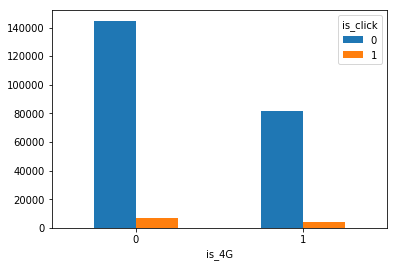

In [390]:
train.groupby('is_4G')['is_click'].value_counts(dropna=False).unstack().plot(kind='bar')
plt.xticks(rotation='horizontal')

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

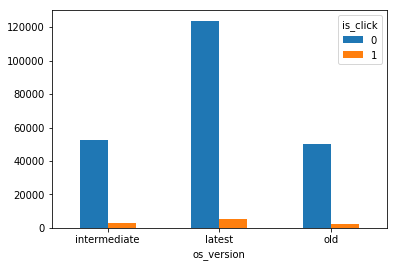

In [391]:
train.groupby('os_version')['is_click'].value_counts(dropna=False).unstack().plot(kind='bar')
plt.xticks(rotation='horizontal')

In [476]:
train['Year'] = train.impression_time.dt.year
train['Quarter'] = train.impression_time.dt.quarter
train['Month'] = train.impression_time.dt.month
train['Day'] = train.impression_time.dt.day
train['Day_Of_Week'] = train.impression_time.dt.dayofweek
train['Is_Month_Start'] = train.impression_time.dt.is_month_start
train['Is_Month_End'] = train.impression_time.dt.is_month_end
train['Is_Quarter_Start'] = train.impression_time.dt.is_quarter_start
train['Is_Quarter_End'] = train.impression_time.dt.is_quarter_start
train['Time'] = train.impression_time.dt.time
train['Hour'] = train.impression_time.dt.hour

def f(x):
    if ((x['Hour']>4)&(x['Hour']<6)):
        return "Dawn"
    elif ((x['Hour']>=6)&(x['Hour']<11)):
        return "Morning"
    elif ((x['Hour']>=11)&(x['Hour']<13)):
        return "Noon"
    elif ((x['Hour']>=13)&(x['Hour']<16)):
        return "After Noon"
    elif ((x['Hour']>=16)&(x['Hour']<19)):
        return "Evening"
    elif ((x['Hour']>=19)&(x['Hour']<23)):
        return "Night"
    else:
        return "Mid Night"
train['TimeOfDay'] = train.apply(f,axis=1)

In [393]:
# Since Year variable has just one value, it does not impart any information, it makes sense to delete it.
train.Year.value_counts(dropna=False)

2018    237609
Name: Year, dtype: int64

In [394]:
# Since Quarter variable has just one value, it does not impart any information, it makes sense to delete it.
train.Quarter.value_counts(dropna=False)

4    237609
Name: Quarter, dtype: int64

In [395]:
train.Month.value_counts(dropna=False)

11    131317
12    106292
Name: Month, dtype: int64

Text(0,0.5,'Count')

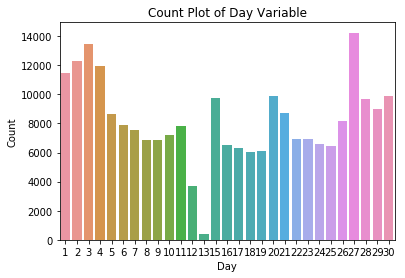

In [396]:
sns.countplot(train['Day'])
plt.title("Count Plot of Day Variable")
plt.xlabel("Day")
plt.ylabel('Count')

Text(0,0.5,'Count')

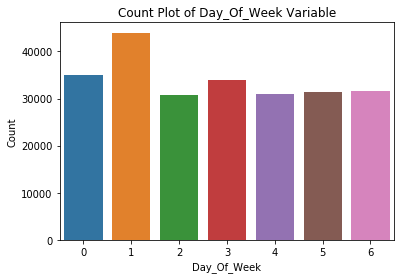

In [397]:
sns.countplot(train['Day_Of_Week'])
plt.title("Count Plot of Day_Of_Week Variable")
plt.xlabel("Day_Of_Week")
plt.ylabel('Count')

Text(0.5,1,'Count plot of Hour of the day')

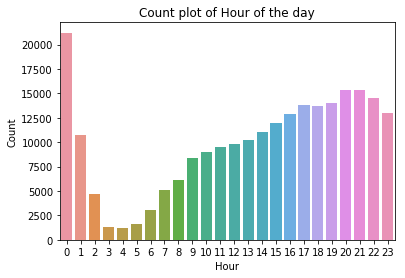

In [398]:
sns.countplot(train['Hour'])
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Count plot of Hour of the day")

Text(0.5,1,'Count plot of Time of the day')

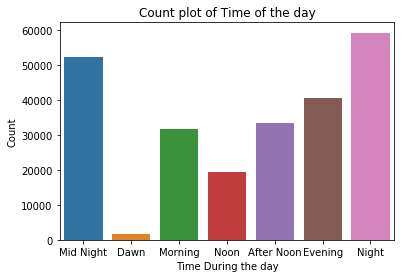

In [399]:
sns.countplot(train['TimeOfDay'])
plt.xlabel("Time During the day")
plt.ylabel("Count")
plt.title("Count plot of Time of the day")

In [477]:
train.drop(['impression_time','Year','Quarter','Time'],axis=1,inplace=True)

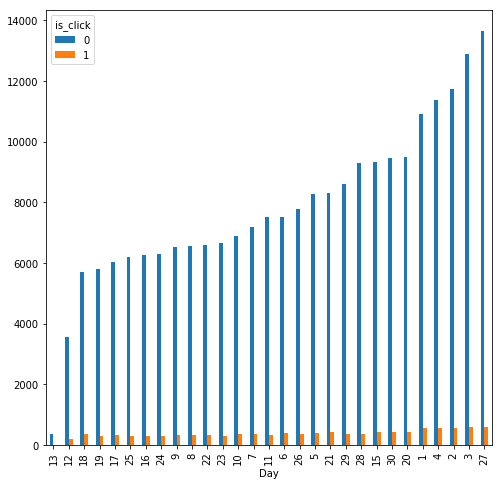

In [401]:
train.groupby('Day')['is_click'].value_counts().unstack().sort_values(by=0).plot(kind='bar',figsize=(8,8))

Text(0,0.5,'Number of Clicks')

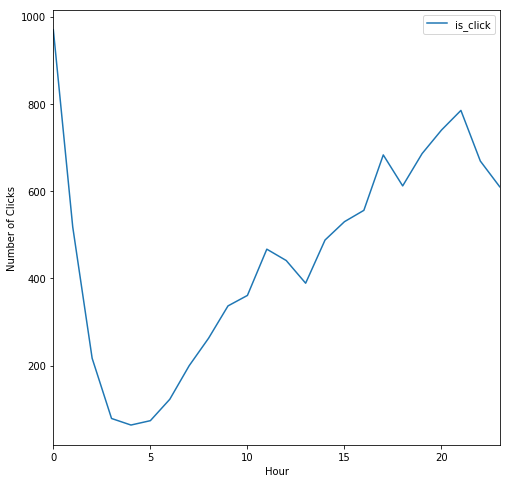

In [402]:
train.groupby('Hour').agg({'is_click':'sum'}).plot(figsize=(8,8))
plt.xlabel("Hour")
plt.ylabel("Number of Clicks")
# We can see that number of clicks is maximum during midnight

Text(0,0.5,'Count')

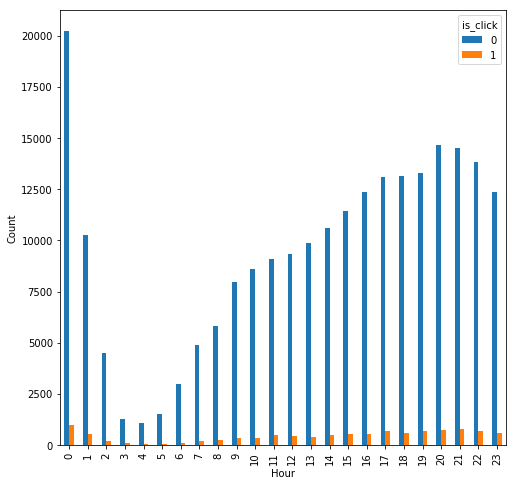

In [403]:
train.groupby(['Hour','is_click']).size().unstack().plot(kind='bar',figsize=(8,8))
plt.xlabel("Hour")
plt.ylabel("Count")

([<matplotlib.axis.XTick at 0x17799d3c5c0>,
 <a list of 7 Text xticklabel objects>)

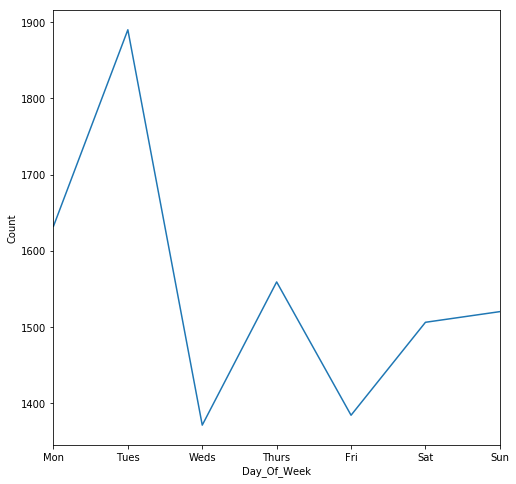

In [404]:
train.groupby(['Day_Of_Week']).agg({'is_click':'sum'}).unstack().plot(figsize=(8,8))
plt.xlabel("Day_Of_Week")
plt.ylabel("Count")
ticks = list(range(0, 7, 1))
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks,labels,rotation='horizontal')

([<matplotlib.axis.XTick at 0x17799d8c3c8>,
 <a list of 7 Text xticklabel objects>)

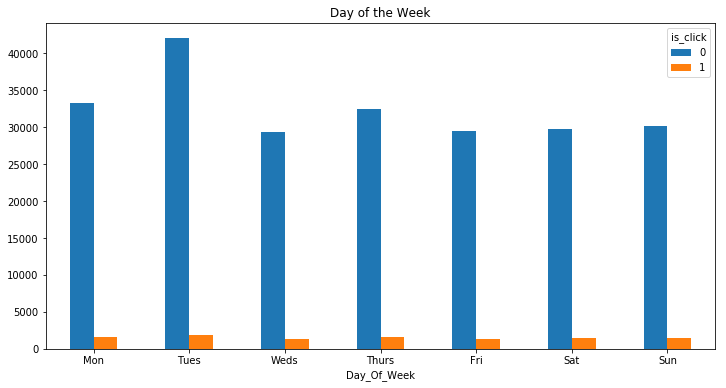

In [405]:
train.groupby(['Day_Of_Week','is_click']).size().unstack().reindex().plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels,rotation='horizontal')

In [478]:
train['Day_Of_Week'].replace({0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"},inplace=True)
train['Month'] = train['Month'].astype('category')
train['Month'] = train['Month'].cat.codes

In [479]:
test['Year'] = test.impression_time.dt.year
test['Quarter'] = test.impression_time.dt.quarter
test['Month'] = test.impression_time.dt.month
test['Day'] = test.impression_time.dt.day
test['Day_Of_Week'] = test.impression_time.dt.dayofweek
test['Is_Month_Start'] = test.impression_time.dt.is_month_start
test['Is_Month_End'] = test.impression_time.dt.is_month_end
test['Is_Quarter_Start'] = test.impression_time.dt.is_quarter_start
test['Is_Quarter_End'] = test.impression_time.dt.is_quarter_start
test['Time'] = test.impression_time.dt.time
test['Hour'] = test.impression_time.dt.hour


def f(x):
    if ((x['Hour']>4)&(x['Hour']<6)):
        return "Dawn"
    elif ((x['Hour']>=6)&(x['Hour']<11)):
        return "Morning"
    elif ((x['Hour']>=11)&(x['Hour']<13)):
        return "Noon"
    elif ((x['Hour']>=13)&(x['Hour']<16)):
        return "After Noon"
    elif ((x['Hour']>=16)&(x['Hour']<19)):
        return "Evening"
    elif ((x['Hour']>=19)&(x['Hour']<23)):
        return "Night"
    else:
        return "Mid Night"
test['TimeOfDay'] = test.apply(f,axis=1)


test.drop(['impression_time','Year','Quarter','Time'],axis=1,inplace=True)


test['Day_Of_Week'].replace({0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"},inplace=True)
test['Month'] = test['Month'].astype('category')
test['Month'] = test['Month'].cat.codes

#### EDA of View Log

In [408]:
view_log.shape

(3118622, 5)

In [409]:
view_log.head()
# Data consists of View Log from 15 November 2018

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [410]:
view_log.tail()

,server_time,device_type,session_id,user_id,item_id
3118617,2018-12-11 23:59:00,android,135534,49480,1013
3118618,2018-12-11 23:59:00,android,206169,70215,44826
3118619,2018-12-11 23:59:00,android,831039,4925,86608
3118620,2018-12-11 23:59:00,android,601193,16870,38284
3118621,2018-12-11 23:59:00,android,138217,1007,88331


Majority of the Devices are Android Devices through which the Zbay site is accessed.

In [411]:
view_log['device_type'].value_counts(dropna=False)

android    3117737
iphone         861
web             24
Name: device_type, dtype: int64

In [412]:
view_log['user_id'].nunique()
# View log has information about 89157 users in total.

89157

In [413]:
view_log['item_id'].nunique()
# A total of 126708 unique items have been accessed by the users. Some have been accessed multiple times.

126708

In [414]:
view_log['item_id'].value_counts(dropna=False).head(10)
# below are most popular items.

425       14821
72955     12930
33633     12711
64835     12008
118262    11816
127900    11102
84704      9182
76404      8838
119516     8761
95249      8745
Name: item_id, dtype: int64

In [415]:
view_log['Year'] = view_log.server_time.dt.year
view_log['Quarter'] = view_log.server_time.dt.quarter
view_log['Month'] = view_log.server_time.dt.month
view_log['Day'] = view_log.server_time.dt.day
view_log['Day_Of_Week'] = view_log.server_time.dt.dayofweek
view_log['Is_Month_Start'] = view_log.server_time.dt.is_month_start
view_log['Is_Month_End'] = view_log.server_time.dt.is_month_end
view_log['Is_Quarter_Start'] = view_log.server_time.dt.is_quarter_start
view_log['Is_Quarter_End'] = view_log.server_time.dt.is_quarter_start
view_log['Time'] = view_log.server_time.dt.time
view_log['Hour'] = view_log.server_time.dt.hour

In [416]:
view_log['Year'].value_counts(dropna=False)
# Data consists of year 2018 only.

2018    3118622
Name: Year, dtype: int64

In [417]:
view_log['Quarter'].value_counts(dropna=False)
# Data consists of Q4 only.

4    3118622
Name: Quarter, dtype: int64

In [418]:
view_log['Month'].value_counts(dropna=False).sort_index()
# Data consists of October, November and December

10     820158
11    1604345
12     694119
Name: Month, dtype: int64

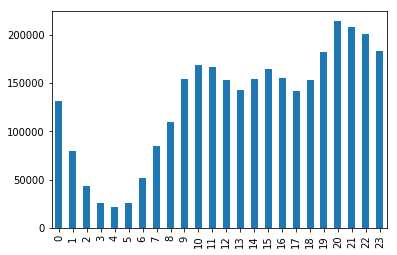

In [419]:
view_log['Hour'].value_counts().sort_index().plot(kind='bar')
# Most hits are during late evening and Midnight.

In [420]:
view_log.drop(['server_time','session_id','Year','Quarter'],axis=1,inplace=True)

#### EDA of Item Data

In [421]:
item_data['item_id'].nunique()
# Item_data has 132761 unique item_id's which is more than the number of unique id's in view_log

132761

In [422]:
item_data['item_price'].describe()

count    132761.00
mean      10826.85
std       28430.19
min           5.00
25%        1324.00
50%        2944.00
75%        8544.00
max     1340800.00
Name: item_price, dtype: float64

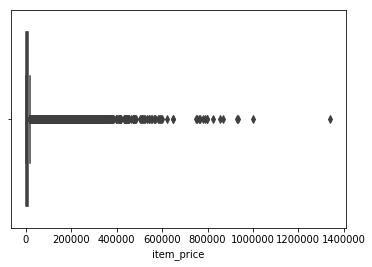

In [423]:
sns.boxplot(item_data['item_price'])
# This variable has a lot of outliers and the range is very high.

In [424]:
item_data['category_1'].nunique()

17

In [425]:
item_data['category_2'].nunique()

79

In [426]:
item_data['category_3'].nunique()

335

In [480]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [481]:
X = train[[col for col in train.columns if col!='is_click']]
y = train['is_click']

In [482]:
X.head()

,user_id,app_code,is_4G,Month,Day,Is_Month_Start,Is_Month_End,Is_Quarter_Start,Is_Quarter_End,Hour,os_version_intermediate,os_version_latest,os_version_old,Day_Of_Week_Fri,Day_Of_Week_Mon,Day_Of_Week_Sat,Day_Of_Week_Sun,Day_Of_Week_Thu,Day_Of_Week_Tue,Day_Of_Week_Wed,TimeOfDay_After Noon,TimeOfDay_Dawn,TimeOfDay_Evening,TimeOfDay_Mid Night,TimeOfDay_Morning,TimeOfDay_Night,TimeOfDay_Noon
0,87862,422,0,0,15,False,False,False,False,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,63410,467,1,0,15,False,False,False,False,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,71748,259,1,0,15,False,False,False,False,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,69209,244,1,0,15,False,False,False,False,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,62873,473,0,0,15,False,False,False,False,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [483]:
X.drop(['Is_Quarter_Start','Is_Quarter_End'],axis=1,inplace=True)
test.drop(['Is_Quarter_Start','Is_Quarter_End'],axis=1,inplace=True)

C:\Users\m1013523\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [484]:
xgbc = xgb.XGBClassifier(n_jobs=-1,random_state=42,scale_pos_weight=20)
params = {"n_estimators":list(range(50,1001,100)),
          "learning_rate":[0.005,0.001,0.05,0.01,0.1,0.5],
          "colsample_bytree":[0.5,0.6,0.7,0.8,0.9],
          "colsample_bylevel":[0.5,0.7,0.9],
          "max_depth":list(range(5,16,2)),
          "subsample":[0.5,0.6,0.7,0.8,0.9],
          "gamma":[0.5,1,1.5,2,5,10],
          "reg_alpha":[1,2,5,10,50,100]}
random_search = RandomizedSearchCV(estimator=xgbc,param_distributions=params,cv=5,scoring='roc_auc')
random_search.fit(X,y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=-1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=42, reg_alpha=0,
                                           reg_lambda=1, sca...
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.5, 1, 1.5, 2, 5, 10],

In [485]:
random_search.best_estimator_,random_search.best_params_,random_search.best_score_

(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
               colsample_bytree=0.9, gamma=5, learning_rate=0.001,
               max_delta_step=0, max_depth=13, min_child_weight=1, missing=None,
               n_estimators=50, n_jobs=-1, nthread=None,
               objective='binary:logistic', random_state=42, reg_alpha=50,
               reg_lambda=1, scale_pos_weight=20, seed=None, silent=True,
               subsample=0.8),
 {'colsample_bylevel': 0.9,
  'colsample_bytree': 0.9,
  'gamma': 5,
  'learning_rate': 0.001,
  'max_depth': 13,
  'n_estimators': 50,
  'reg_alpha': 50,
  'subsample': 0.8},
 0.6833175134075921)

In [486]:
ser = pd.Series(random_search.best_estimator_.feature_importances_,X.columns).sort_values()
ser

TimeOfDay_Dawn            0.01
Is_Month_Start            0.01
Day_Of_Week_Mon           0.01
Is_Month_End              0.01
Day_Of_Week_Wed           0.01
TimeOfDay_After Noon      0.01
Day_Of_Week_Fri           0.01
TimeOfDay_Noon            0.01
TimeOfDay_Evening         0.02
Day_Of_Week_Thu           0.02
Day_Of_Week_Tue           0.02
Day_Of_Week_Sat           0.02
Day_Of_Week_Sun           0.02
Day                       0.02
Month                     0.02
os_version_old            0.02
user_id                   0.02
Hour                      0.02
TimeOfDay_Morning         0.02
is_4G                     0.03
TimeOfDay_Night           0.03
os_version_intermediate   0.03
TimeOfDay_Mid Night       0.04
os_version_latest         0.10
app_code                  0.47
dtype: float32

In [ ]:
Submission['is_click'] = random_search.predict(test)
Submission.to_csv("Tenth.csv",index=None)